# Student Name: Saeedreza Zouashkiani
# Student ID: 400206262

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import os
from utils import calculate_metrics, count_parameters

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter('runs/q1/fc')

In [3]:
# initialize the dataset and split it into train and test sets with a ratio of 70:30
# transform normalize and resize the images to 150*150
transform = transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.ImageFolder(root='Shoe vs Sandal vs Boot Dataset', transform=transform)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

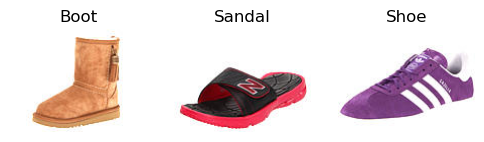

In [3]:
def plot_images(num_images=1, root_dir="Shoe vs Sandal vs Boot Dataset"):
    classes = os.listdir(root_dir)
    plt.figure(figsize=(len(classes) * 2, num_images * 2))
    for i in range(len(classes)):
        for j in range(num_images):
            # get a random image from the class
            img_name = np.random.choice(os.listdir(os.path.join(root_dir, classes[i])))
            img_path = os.path.join(root_dir, classes[i], img_name)
            img = plt.imread(img_path)
            plt.subplot(num_images, len(classes), i * num_images + j + 1)
            plt.imshow(img)
            plt.title(classes[i])
            plt.axis("off")
    plt.show()
plot_images()

In [4]:
class MLP(nn.Module):
    def __init__(self, hidden_layers):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_layers) - 1):
            self.hidden_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        for i, linear in enumerate(self.hidden_layers):
            if i != len(self.hidden_layers) - 1:
                x = F.relu(linear(x))
                x = self.dropout(x)
            else:
                x = self.softmax(linear(x))
        return x

In [4]:
# define a function to train on the train set and return the loss and accuracy of train and test sets
# add the loss and accuracy to the tensorboard for each epoch
def train(model, optimizer, train_loader, test_loader, epochs, criterion):
    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []
    for epoch in range(epochs):
        train_loss = 0
        test_loss = 0
        train_correct = 0
        test_correct = 0
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            train_correct += pred.eq(labels.view_as(pred)).sum().item()
        train_losses.append(train_loss / len(train_loader))
        train_acc.append(train_correct / len(train_loader.dataset))
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                loss = criterion(output, labels)
                test_loss += loss.item()
                pred = output.argmax(dim=1, keepdim=True)
                test_correct += pred.eq(labels.view_as(pred)).sum().item()
        test_losses.append(test_loss / len(test_loader))
        test_acc.append(test_correct / len(test_loader.dataset))
        print(f'Epoch: {epoch + 1}/{epochs}, '
                f'Train loss: {train_loss / len(train_loader):.3f}, '
                f'Train accuracy: {train_correct / len(train_loader.dataset):.3f}, '
                f'Test loss: {test_loss / len(test_loader):.3f}, '
                f'Test accuracy: {test_correct / len(test_loader.dataset):.3f}')
        
        writer.add_scalar('Loss/train', train_loss / len(train_loader), epoch)
        writer.add_scalar('Loss/test', test_loss / len(test_loader), epoch)
        writer.add_scalar('Accuracy/train', train_correct / len(train_loader.dataset), epoch)
        writer.add_scalar('Accuracy/test', test_correct / len(test_loader.dataset), epoch)
    return train_losses, test_losses, train_acc, test_acc

In [6]:
hidden_layers = [150 * 150 * 3, 128, 64, 3]
criterion = nn.CrossEntropyLoss()
fc_model = MLP(hidden_layers).to(device)
# add the model to the tensorboard
writer.add_graph(fc_model, torch.rand(1, 3, 150, 150).to(device))
writer.close()

optimizer = optim.Adam(fc_model.parameters(), lr=1e-4)
train_loss, test_loss, train_acc, test_acc = train(fc_model, optimizer, train_loader, test_loader, epochs=10, criterion=criterion)
# save the model
torch.save(fc_model.state_dict(), "fc_model.pt")

Epoch: 1/10, Train loss: 0.755, Train accuracy: 0.796, Test loss: 0.746, Test accuracy: 0.800
Epoch: 2/10, Train loss: 0.701, Train accuracy: 0.851, Test loss: 0.669, Test accuracy: 0.880
Epoch: 3/10, Train loss: 0.681, Train accuracy: 0.870, Test loss: 0.666, Test accuracy: 0.884
Epoch: 4/10, Train loss: 0.661, Train accuracy: 0.891, Test loss: 0.651, Test accuracy: 0.898
Epoch: 5/10, Train loss: 0.653, Train accuracy: 0.899, Test loss: 0.642, Test accuracy: 0.910
Epoch: 6/10, Train loss: 0.654, Train accuracy: 0.897, Test loss: 0.644, Test accuracy: 0.906
Epoch: 7/10, Train loss: 0.642, Train accuracy: 0.911, Test loss: 0.646, Test accuracy: 0.903
Epoch: 8/10, Train loss: 0.642, Train accuracy: 0.909, Test loss: 0.640, Test accuracy: 0.909
Epoch: 9/10, Train loss: 0.632, Train accuracy: 0.920, Test loss: 0.629, Test accuracy: 0.923
Epoch: 10/10, Train loss: 0.631, Train accuracy: 0.922, Test loss: 0.627, Test accuracy: 0.923


The model has 8,648,579 trainable parameters
------------------Classification Report------------------
		 precision 	 recall 	 f1-score 	 support
Boot 		 0.965 		 0.928 		 0.946 		 1477
Sandal 		 0.855 		 0.960 		 0.904 		 1521
Shoe 		 0.951 		 0.886 		 0.917 		 1502
--------------------------------------------------------
Accuracy: 					 0.923 		 4500
Error rate: 					 0.077 		 4500
Macro avg: 	 0.923 		 0.925 		 0.924 		 4500
Weighted avg: 	 0.923 		 0.923 		 0.923 		 4500
--------------------------------------------------------



------------------Confusion Matrix------------------


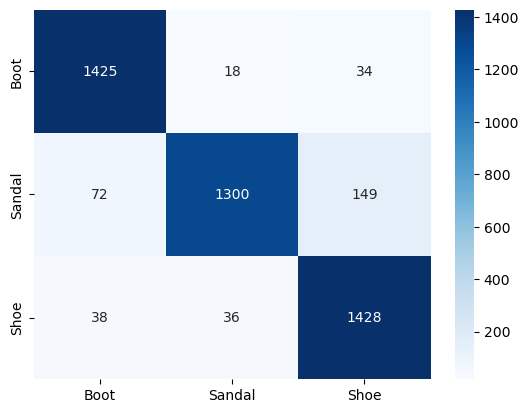

In [7]:
print(f'The model has {count_parameters(fc_model):,} trainable parameters')    
calculate_metrics(fc_model, test_loader, device=device)

In [8]:
class CNN(nn.Module):
    def __init__(self, block_dropout=True):
        super(CNN, self).__init__()
        self.block_dropout = block_dropout
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 18 * 18, 400)
        self.fc2 = nn.Linear(400, 3)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.batchnorm4 = nn.BatchNorm1d(400)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.maxpool(F.relu(self.batchnorm1(self.conv1(x))))
        if self.block_dropout:
            x = F.dropout2d(x, 0.2, training=self.training)
        else:
            x = F.dropout(x, 0.2, training=self.training)
        x = self.maxpool(F.relu(self.batchnorm2(self.conv2(x))))
        if self.block_dropout:
            x = F.dropout2d(x, 0.2, training=self.training)
        else:
            x = F.dropout(x, 0.2, training=self.training)
        x = self.maxpool(F.relu(self.batchnorm3(self.conv3(x))))
        if self.block_dropout:
            x = F.dropout2d(x, 0.2, training=self.training)
        else:
            x = F.dropout(x, 0.2, training=self.training)
        x = x.view(-1, 64 * 18 * 18)
        x = F.relu(self.batchnorm4(self.fc1(x)))
        x = F.dropout(x, 0.2, training=self.training)
        x = self.softmax(self.fc2(x))
        return x

In [9]:
# initialize the model and move it to GPU and add to tensorboard
writer = SummaryWriter("runs/q1_cnn_dropout")
cnn_model = CNN(block_dropout=False).to(device)
writer.add_graph(cnn_model, torch.rand(1, 3, 150, 150).to(device))

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4)

# train the model
cnn_train_losses, cnn_train_acc, cnn_test_losses, cnn_test_acc = train(cnn_model, optimizer, train_loader,test_loader, 10, criterion)
# save the model
torch.save(cnn_model.state_dict(), "cnn_model_droput.pt")

Epoch: 1/10, Train loss: 0.684, Train accuracy: 0.884, Test loss: 0.840, Test accuracy: 0.698
Epoch: 2/10, Train loss: 0.626, Train accuracy: 0.944, Test loss: 0.883, Test accuracy: 0.640
Epoch: 3/10, Train loss: 0.608, Train accuracy: 0.953, Test loss: 0.678, Test accuracy: 0.882
Epoch: 4/10, Train loss: 0.598, Train accuracy: 0.965, Test loss: 0.686, Test accuracy: 0.883
Epoch: 5/10, Train loss: 0.591, Train accuracy: 0.968, Test loss: 0.677, Test accuracy: 0.885
Epoch: 6/10, Train loss: 0.584, Train accuracy: 0.975, Test loss: 0.616, Test accuracy: 0.942
Epoch: 7/10, Train loss: 0.582, Train accuracy: 0.978, Test loss: 0.656, Test accuracy: 0.901
Epoch: 8/10, Train loss: 0.577, Train accuracy: 0.980, Test loss: 0.635, Test accuracy: 0.921
Epoch: 9/10, Train loss: 0.577, Train accuracy: 0.980, Test loss: 0.646, Test accuracy: 0.909
Epoch: 10/10, Train loss: 0.573, Train accuracy: 0.984, Test loss: 0.608, Test accuracy: 0.950


The model has 8,320,611 trainable parameters
------------------Classification Report------------------
		 precision 	 recall 	 f1-score 	 support
Boot 		 0.993 		 0.926 		 0.959 		 1477
Sandal 		 0.900 		 0.991 		 0.943 		 1521
Shoe 		 0.957 		 0.937 		 0.947 		 1502
--------------------------------------------------------
Accuracy: 					 0.950 		 4500
Error rate: 					 0.050 		 4500
Macro avg: 	 0.950 		 0.951 		 0.951 		 4500
Weighted avg: 	 0.950 		 0.950 		 0.950 		 4500
--------------------------------------------------------



------------------Confusion Matrix------------------


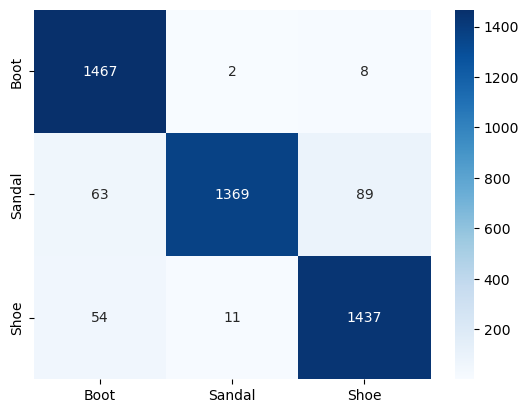

In [10]:
print(f'The model has {count_parameters(cnn_model):,} trainable parameters')
calculate_metrics(cnn_model, test_loader, device=device)

In [11]:
# initialize the model and move it to GPU and add to tensorboard
writer = SummaryWriter("runs/q1_cnn_block_dropout")
cnn_model_dropout = CNN(block_dropout=True).to(device)
writer.add_graph(cnn_model_dropout, torch.rand(1, 3, 150, 150).to(device))

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model_dropout.parameters(), lr=1e-4)

# train the model
cnn_train_losses, cnn_train_acc, cnn_test_losses, cnn_test_acc = train(cnn_model_dropout, optimizer, train_loader,test_loader, 10, criterion)
# save the model
torch.save(cnn_model_dropout.state_dict(), "cnn_model_block_dropout.pt")

Epoch: 1/10, Train loss: 0.716, Train accuracy: 0.849, Test loss: 0.656, Test accuracy: 0.912
Epoch: 2/10, Train loss: 0.642, Train accuracy: 0.926, Test loss: 0.624, Test accuracy: 0.937
Epoch: 3/10, Train loss: 0.623, Train accuracy: 0.943, Test loss: 0.609, Test accuracy: 0.948
Epoch: 4/10, Train loss: 0.615, Train accuracy: 0.947, Test loss: 0.598, Test accuracy: 0.959
Epoch: 5/10, Train loss: 0.605, Train accuracy: 0.956, Test loss: 0.604, Test accuracy: 0.955
Epoch: 6/10, Train loss: 0.599, Train accuracy: 0.961, Test loss: 0.600, Test accuracy: 0.956
Epoch: 7/10, Train loss: 0.593, Train accuracy: 0.966, Test loss: 0.593, Test accuracy: 0.962
Epoch: 8/10, Train loss: 0.592, Train accuracy: 0.969, Test loss: 0.597, Test accuracy: 0.958
Epoch: 9/10, Train loss: 0.584, Train accuracy: 0.973, Test loss: 0.586, Test accuracy: 0.969
Epoch: 10/10, Train loss: 0.583, Train accuracy: 0.976, Test loss: 0.584, Test accuracy: 0.970


The model has 8,320,611 trainable parameters
------------------Classification Report------------------
		 precision 	 recall 	 f1-score 	 support
Boot 		 0.991 		 0.960 		 0.975 		 1477
Sandal 		 0.959 		 0.983 		 0.971 		 1521
Shoe 		 0.959 		 0.966 		 0.963 		 1502
--------------------------------------------------------
Accuracy: 					 0.970 		 4500
Error rate: 					 0.030 		 4500
Macro avg: 	 0.970 		 0.970 		 0.970 		 4500
Weighted avg: 	 0.970 		 0.970 		 0.970 		 4500
--------------------------------------------------------



------------------Confusion Matrix------------------


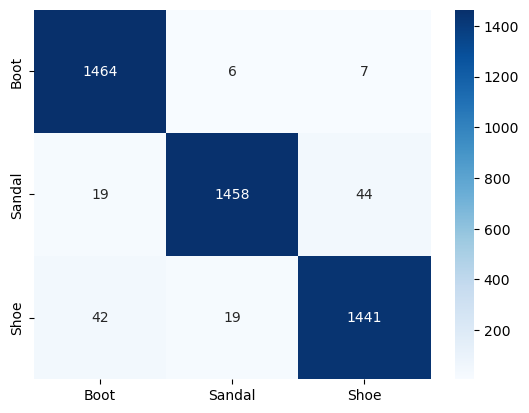

In [12]:
print(f'The model has {count_parameters(cnn_model_dropout):,} trainable parameters')
calculate_metrics(cnn_model_dropout, test_loader, device=device)

In [5]:
class CNN_factorized(nn.Module):
    def __init__(self, block_dropout=True):
        super(CNN_factorized, self).__init__()
        self.block_dropout = block_dropout
        self.depth_conv1 = nn.Conv2d(3, 3, kernel_size=3, padding=1, groups=3)
        self.point_conv1 = nn.Conv2d(3, 16, kernel_size=1)
        self.depth_conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1, groups=16)
        self.point_conv2 = nn.Conv2d(16, 32, kernel_size=1)
        self.depth_conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32)
        self.point_conv3 = nn.Conv2d(32, 64, kernel_size=1)
        self.depthwise_seperable_conv1 = nn.Sequential(self.depth_conv1, self.point_conv1)
        self.depthwise_seperable_conv2 = nn.Sequential(self.depth_conv2, self.point_conv2)
        self.depthwise_seperable_conv3 = nn.Sequential(self.depth_conv3, self.point_conv3)
        self.fc1 = nn.Linear(64 * 18 * 18, 400)
        self.fc2 = nn.Linear(400, 3)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.batchnorm4 = nn.BatchNorm1d(400)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.maxpool(F.relu(self.batchnorm1(self.depthwise_seperable_conv1(x))))
        if self.block_dropout:
            x = F.dropout2d(x, 0.2, training=self.training)
        else:
            x = F.dropout(x, 0.2, training=self.training)
        x = self.maxpool(F.relu(self.batchnorm2(self.depthwise_seperable_conv2(x))))
        if self.block_dropout:
            x = F.dropout2d(x, 0.2, training=self.training)
        else:
            x = F.dropout(x, 0.2, training=self.training)
        x = self.maxpool(F.relu(self.batchnorm3(self.depthwise_seperable_conv3(x))))
        if self.block_dropout:
            x = F.dropout2d(x, 0.2, training=self.training)
        else:
            x = F.dropout(x, 0.2, training=self.training)
        x = x.view(-1, 64 * 18 * 18)
        x = F.relu(self.batchnorm4(self.fc1(x)))
        x = F.dropout(x, 0.2, training=self.training)
        x = self.softmax(self.fc2(x))
        return x

In [6]:
# initialize the model and move it to GPU and add to tensorboard
writer = SummaryWriter("runs/q1_cnn_factorized")
cnn_model_factorized = CNN_factorized().to(device)
writer.add_graph(cnn_model_factorized, torch.rand(1, 3, 150, 150).to(device))

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model_factorized.parameters(), lr=1e-4)

# train the model
cnn_factorized_train_losses, cnn_factorized_train_acc, cnn_factorized_test_losses, cnn_factorized_test_acc = train(cnn_model_factorized, optimizer, train_loader,test_loader, 10, criterion)
writer.close()
# save the model
torch.save(cnn_model_factorized.state_dict(), "cnn_model__factorized.pt")

Epoch: 1/10, Train loss: 0.730, Train accuracy: 0.835, Test loss: 0.668, Test accuracy: 0.896
Epoch: 2/10, Train loss: 0.662, Train accuracy: 0.904, Test loss: 0.637, Test accuracy: 0.932
Epoch: 3/10, Train loss: 0.643, Train accuracy: 0.921, Test loss: 0.623, Test accuracy: 0.938
Epoch: 4/10, Train loss: 0.631, Train accuracy: 0.935, Test loss: 0.626, Test accuracy: 0.937
Epoch: 5/10, Train loss: 0.621, Train accuracy: 0.940, Test loss: 0.609, Test accuracy: 0.948
Epoch: 6/10, Train loss: 0.613, Train accuracy: 0.946, Test loss: 0.613, Test accuracy: 0.941
Epoch: 7/10, Train loss: 0.606, Train accuracy: 0.953, Test loss: 0.604, Test accuracy: 0.955
Epoch: 8/10, Train loss: 0.601, Train accuracy: 0.957, Test loss: 0.603, Test accuracy: 0.952
Epoch: 9/10, Train loss: 0.597, Train accuracy: 0.961, Test loss: 0.603, Test accuracy: 0.952
Epoch: 10/10, Train loss: 0.594, Train accuracy: 0.964, Test loss: 0.597, Test accuracy: 0.958


# Train and test losses
<span style="color:#425066">⬤</span> FC model
<span style="color:#12b5cb">⬤</span> CNN model with simple dropout
<span style="color:#e52592">⬤</span> CNN model with block dropout
<span style="color:#f9ab00">⬤</span> CNN model with depthwise separable convolution

<img src="Figures/Loss_train.png" alt="drawing" height="300"/>
<img src="Figures/Loss_test.png" alt="drawing" height="300"/>

# Train and test accuracies
<span style="color:#425066">⬤</span> FC model
<span style="color:#12b5cb">⬤</span> CNN model with simple dropout
<span style="color:#e52592">⬤</span> CNN model with block dropout
<span style="color:#f9ab00">⬤</span> CNN model with depthwise separable convolution

<img src="Figures/Accuracy_train.png" alt="drawing" height="300"/>
<img src="Figures/Accuracy_test.png" alt="drawing" height="300"/>

As described in the paper Efficient Object Localization Using Convolutional Networks , if adjacent pixels within feature maps are strongly correlated (as is normally the case in early convolution layers) then i.i.d. dropout will not regularize the activations and will otherwise just result in an effective learning rate decrease.